In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from collections import OrderedDict

exclude_pids = {'6676de84b74db82737117749', '664cd4c569b0ca543a5adb59', '654e5bcb8cb6aeb8ca9b33a0', '60ff7628cf95f937e0b38a59', '61679f24fb77ff4978222991', '615251a465f058e211cfbbb8', '5dd6dadf9c84d86703aa8615', '666cec25f497139cf74c603b', '660e3fb2bad720864d309383', '6631065eb63cbeb3ae33df79', '63bed6e176fba857a47fbaff', '65a6900704afb0a6f2f893d4', '668185ec7fbceb728648bef8', '65cc40f32b3565cba17be5b9', '60933bb6e47eb28c880b93d9', '652da7c42cac6d10ff9de007', '667c2bf3e72bd528d91f3945', '603421c858a3bd213d7c24b2', '63fceba525d21052bc1ee390', '660c87ac0012e87d84862040', '5d5035c5d87393001af70561', '655fd9d5bb03869d53e75f4e', '64528f4d51f889c0c30573af', '6138df3f784ed068ae002cb3', '663fd4658572150cc2416c27', '5e2380c152e7a66358a276c5', '660b812f113edc37de1df2b3', '665d090fbf7bc5f5f2017579', '5e6fd38fe95be7071b5196bf', '5ff39ec71d6cb49c6c906727', '6678d8896975ae6f30bebb23', '664f3e284d10edcbd80ed29e', '65798ffea5411209c86f31df', '6668546da091d077d6a6d9b7', '664d1abb1121d570eb3f8159', '61215755cea9b916eef0a38b', '604011377e5b121dc3267a3e', '6414be45ec452483d7579868', '65086209d6edf5f2cf5f05d4', '57ab3f8321e5a50001562cd3', '5bad4db8b712f30001b87990', '65c630cc3824e0cf64dd2f7a', '5b197b8088ee7400012ae154', '6526246367b37eef371ba914', '65ba2af02a6a7f08d9e2b6c2', '6633381060353bc96809fc95', '603000ac19eaccdcf8b92e62', '66677f2413cf52589fdc2faa', '613ad21e63b6c74708c223a9', '6678de07a0590af4e54e9194', '63d54c4128bf8c671033ade4', '661939712ce7ac67b60ab773', '60fd64fd34ee5940500d499f', '5fd79aba1833640f79ffd07d', '65e5e9c2c0bfcbcbe835ec4d', '614fe09fec9ce4a2a415476d'}

# weird bug in the navigation UI
exclude_pids.add('60fd0b299f6ddde5fda27a9e')

In [2]:
def fix_lng_cols(text):
    if type(text) == float:
        return 'NONE'
        
    text = text.strip().lower()
    text = text.replace('language', '')
    text = text.strip()
    if text in ['english', 'enlgish', 'englis', 'eng']:
        return 'ENG'
    if text in ['spanish']:
        return 'ES'
    if 'eng' in text and 'spa' in text:
        return 'BOTH'
    if text in ['portuguese']:
        return 'NONE'
    else:
        return 'NONE'


self_rate_categories = ['Reading', 'Writing', 'Speaking', 'Listening']

self_usage_categories = ['At work', 'At home',
                         'Interacting with friends',
                         'Interacting with family',
                         'Entertainment (TV series, music, etc.)']

def get_self_rate_base_q(lng: str):
    return f'How would you rate your fluency in your {lng} language, for each of these categories:'

def get_self_usage_base_q(lng: str):
    return f'Please rate how likely you are to use your {lng} language in the following contexts:'

def get_lng_proficiency(lng: str, df_copy):
    # either 'native' or 'second'
    self_rate_base = get_self_rate_base_q(lng)
    self_usage_base = get_self_usage_base_q(lng)

    self_rate_questions = [f'{self_rate_base} {c}' for c in self_rate_categories]
    self_usage_questions = [f'{self_usage_base} {c}' for c in self_usage_categories]
    
    questions = self_rate_questions + self_usage_questions
    return df_copy[questions].mean(axis=1).copy()


def append_to_ordered_lng_dict(lng_dict: dict, data: list):
    for i, name in enumerate(lng_dict):
        lng_dict[name].append(data[i])

    
def fix_lng_data(df):
    df['lng_1'] = df['Enter your native language, or the language you are providing answers for, here:'].apply(fix_lng_cols)
    df['lng_2'] = df['Enter your most proficient second language here:'].apply(fix_lng_cols)
    
    lng1_prof_list = get_lng_proficiency('native', df)
    df = df.assign(lng1_prof=lng1_prof_list)
    
    lng2_prof_list = get_lng_proficiency('second', df)
    df = df.assign(lng2_prof=lng2_prof_list)

    eng_data = OrderedDict()
    eng_data['prof'] = []

    spa_data = OrderedDict()
    spa_data['prof'] = []

    for name in self_rate_categories:
        eng_data[name] = []
        spa_data[name] = []

    for name in self_usage_categories:
        eng_data[name] = []
        spa_data[name] = []

    l1_self_rate_base = get_self_rate_base_q('native')
    l1_self_usage_base = get_self_usage_base_q('native')
    l1_columns = ['lng1_prof']
    l1_columns.extend([f'{l1_self_rate_base} {c}' for c in self_rate_categories])
    l1_columns.extend([f'{l1_self_usage_base} {c}' for c in self_usage_categories])  

    l2_self_rate_base = get_self_rate_base_q('second')
    l2_self_usage_base = get_self_usage_base_q('second')
    l2_columns = ['lng2_prof']
    l2_columns.extend([f'{l2_self_rate_base} {c}' for c in self_rate_categories])
    l2_columns.extend([f'{l2_self_usage_base} {c}' for c in self_usage_categories])  

    features_len = len(l1_columns)

    for i, (lng1, lng2) in df[['lng_1', 'lng_2']].iterrows():
        l1_data = list(df.iloc[i][l1_columns])
        l2_data = list(df.iloc[i][l2_columns])

        if lng1 == 'ENG' and lng2 == 'ES':
            append_to_ordered_lng_dict(eng_data, l1_data)
            append_to_ordered_lng_dict(spa_data, l2_data)
        elif lng1 == 'ES' and lng2 == 'ENG':
            append_to_ordered_lng_dict(spa_data, l1_data)
            append_to_ordered_lng_dict(eng_data, l2_data)
        elif lng1 == 'BOTH':
            append_to_ordered_lng_dict(spa_data, l1_data)
            append_to_ordered_lng_dict(eng_data, l1_data)              
        elif lng2 == 'BOTH':
            append_to_ordered_lng_dict(spa_data, l2_data)
            append_to_ordered_lng_dict(eng_data, l2_data)            
        #edge cases...
        elif lng1 == lng2 == 'ENG':
            append_to_ordered_lng_dict(eng_data, l1_data)
            append_to_ordered_lng_dict(spa_data, [None] * features_len)  
        elif lng1 == lng2 == 'ES':
            append_to_ordered_lng_dict(spa_data, l1_data)
            append_to_ordered_lng_dict(eng_data, [None] * features_len)              
        elif lng1 == lng2 == 'NONE':
            append_to_ordered_lng_dict(eng_data, [None] * features_len)              
            append_to_ordered_lng_dict(spa_data, [None] * features_len)              
        elif lng1 == 'NONE' and lng2 == 'ENG':
            append_to_ordered_lng_dict(eng_data, l2_data)
            append_to_ordered_lng_dict(spa_data, [None] * features_len)               
        elif lng1 == 'NONE' and lng2 == 'ES':
            append_to_ordered_lng_dict(spa_data, l2_data)
            append_to_ordered_lng_dict(eng_data, [None] * features_len)                
        elif lng2 == 'NONE' and lng1 == 'ENG':
            append_to_ordered_lng_dict(eng_data, l1_data)
            append_to_ordered_lng_dict(spa_data, [None] * features_len)              
        elif lng2 == 'NONE' and lng1 == 'ES':
            append_to_ordered_lng_dict(spa_data, l1_data)
            append_to_ordered_lng_dict(eng_data, [None] * features_len)               
        else:
            print(lng1, l1_data)
            print(lng2, l2_data)
            print()

    for col_name in eng_data:
        eng_col_name = f'eng_{col_name}'
        spa_col_name = f'spa_{col_name}'
        
        df[eng_col_name] = eng_data[col_name]
        df[spa_col_name] = spa_data[col_name]

        print(f' eng {col_name} validation', len(eng_data[col_name]) == len(df))
        print(f' spa {col_name} validation', len(spa_data[col_name]) == len(df))
    
    return df

def rename_cols(df):
    cols_rename = {
        'How much did you enjoy the task?' : 'Q_enjoy',
        "How successful do you think you were at completing the task?" : 'Q_successful',
        "How likely would you be to mix languages in the following contexts? Interacting with friends": "Q_mix_friends",
        'Do you enjoy mixing languages in conversation?': "Q_enjoy_mix",
        "How natural was your conversational partner’s language switching?": "Q_natural",
        "On a day-to-day basis, how likely are you to have a conversation using both English and Spanish?": "Q_mix_often",
        "How difficult was it to communicate with your partner?" : "Q_difficuly_comm",
        "How difficult was it to understand your partner's instructions?" : 'Q_difficuly_ins',
        }
    for col in cols_rename:
        new_col = cols_rename[col]
        df[new_col] = df.loc[:, col]

    # df = df.rename(columns=questions_rename, errors="raise", inplace=False)
    return df

# def simple_task_success(df):
#     data = 420 - df['game_time']
#     normalizedData = (data-np.min(data))/(np.max(data)-np.min(data)) 


In [3]:
df = pd.read_csv('raw_experiments.csv', index_col=0)
print(df.shape)
df = fix_lng_data(df)
print(df.shape)
df = rename_cols(df)
# df.to_csv('experiments_w_lng_data.csv')

(1632, 133)
 eng prof validation True
 spa prof validation True
 eng Reading validation True
 spa Reading validation True
 eng Writing validation True
 spa Writing validation True
 eng Speaking validation True
 spa Speaking validation True
 eng Listening validation True
 spa Listening validation True
 eng At work validation True
 spa At work validation True
 eng At home validation True
 spa At home validation True
 eng Interacting with friends validation True
 spa Interacting with friends validation True
 eng Interacting with family validation True
 spa Interacting with family validation True
 eng Entertainment (TV series, music, etc.) validation True
 spa Entertainment (TV series, music, etc.) validation True
(1632, 157)


In [4]:
df = df[~df.pid.isin(exclude_pids)]
print(len(df))
for col in df.columns:
    print(col)

1492
experiment
human_role
map
pid
game_time
is_time_success
user number of utterances
user mean utterance length
user total number of tokens
user number of eng utterances
user number of es utterances
user number of mix utterances
user number of none utterances
user number of inter-sentential cs
user number of utterances with some ins switch
user number of total ins switches
user number of cong_masc switches
user number of cong_fem switches
user number of incong_masc switches
user number of incong_fem switches
user number of NP switches
user number of amb_masc switches
user number of amb_fem switches
user number of masc det switches
user number of fem det switches
user % entrainment - all dialog
user % entrainment - on bot inter-sentential cs
user number of cong_masc aligned to bot
user number of cong_fem aligned to bot
user number of incong_masc aligned to bot
user number of incong_fem aligned to bot
user number of NP aligned to bot
user number of amb_masc aligned to bot
user number o

In [5]:
alt_experiments = ['Alternation Baseline', 'Alternation Random CS', 'Alternation Short-context CS',
                   'Alternation Alignment CS', 'Alternation Adversarial CS']
ins_experiments = ['Insertional Spanish Baseline', 'Insertional Spanish Congruent','Insertional Spanish Masculine InCongruent',
                   'Insertional Spanish Feminine InCongruent']
global_exp_ =  'both' #'ins' # 'alt'

if global_exp_ == 'both':
    experiments = alt_experiments
    experiments.extend(ins_experiments)
else:
    experiments = ins_experiments if global_exp_ == 'ins' else alt_experiments
role = 'all' #'all' #'instructor' #'navigator'


In [6]:
def get_experiment_df(exp: list[str]):
    new_df = df[df['experiment'].isin(exp)]
    if role == 'all':
        return new_df
    return new_df[new_df['human_role'] == role]


def remove_rename_columns(df, remove=True):

    if remove:
        remove_cols = ['human_role', 'experiment', 'map', 'pid']
        all_cols = list(df.columns)
        remove_cols.extend(list(filter(lambda x: 'bot_' in x, all_cols)))
        df = df.drop(remove_cols, axis=1)
        
    df["English %"] = df["user number of eng utterances"] / df["user number of utterances"] *100 
    df["None %"] = df["user number of none utterances"] / df["user number of utterances"] *100 
    df["Spanish %"] = df["user number of es utterances"] / df["user number of utterances"]  *100
    df["Mix %"] = df["user number of mix utterances"] / df["user number of utterances"]  *100
    
    df["Inter-Sentential CS %"] = df["user number of inter-sentential cs"] / (df["user number of utterances"] - 1)  *100

    df['% entrainment - on bot inter-sentential cs'] = df['user % entrainment - on bot inter-sentential cs'] * 100
    df['% entrainment - all dialog'] = df['user % entrainment - all dialog'] * 100

    # remove custom na
    if global_exp_ == 'ins':
        df = df.drop(df.loc[df['Q_natural'] == 'na'].index)
        df = df.drop(df.loc[df['Q_mix_often'] == 'na'].index)

    df = df.drop(df.loc[df['Q_mix_friends'] == 'na'].index)
    df = df.drop(df.loc[df['Q_enjoy_mix'] == 'na'].index)

    df['Q_mix_friends'] = df['Q_mix_friends'].astype(int)
    df['Q_enjoy_mix'] = df['Q_enjoy_mix'].astype(int)

    if global_exp_ == 'ins':
        df['Q_natural'] = df['Q_natural'].astype(int)
        df['Q_mix_often'] = df['Q_mix_often'].astype(int)


    return df

In [7]:
def plot_corr_matt(df, title):
    f = plt.figure(figsize=(15, 15))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(f'{title} - Correlation Matrix', fontsize=16)

    
def plot_2d_scatter(df, title, x, y, color, size):
    print(df.shape)
    fig = px.scatter(df, x=x, y=y, color=color, size=size, title=title)
    fig.show()

In [8]:
df_copy = get_experiment_df(experiments)
df_copy = remove_rename_columns(df_copy, False)
print(df_copy.shape)
print(df_copy['experiment'].value_counts())

(1464, 172)
experiment
Alternation Baseline                         176
Alternation Short-context CS                 172
Insertional Spanish Baseline                 164
Insertional Spanish Congruent                164
Alternation Alignment CS                     160
Insertional Spanish Feminine InCongruent     160
Alternation Adversarial CS                   160
Insertional Spanish Masculine InCongruent    156
Alternation Random CS                        152
Name: count, dtype: int64


Filter switchers?

In [9]:
# df_copy = df_copy[df_copy['Q_enjoy_mix'] >= 50]
# df_copy = df_copy[df_copy['Mix %'] > 0]
# df_copy.shape

<Axes: >

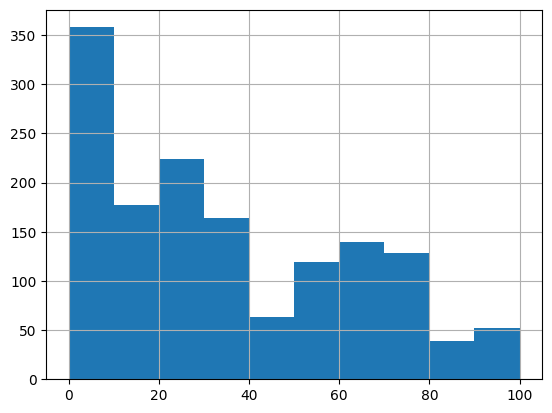

In [10]:
df_copy['Q_difficuly_ins'].hist()
# df_copy['Q_natural'].hist()
# df_copy = df_copy[df_copy['spa_prof'] >= 50]
# df_copy.shape

user number of incong_masc switches - 8 participants, 9 chats, 10 switches
human_role
instructor    6
navigator     3
Name: count, dtype: int64


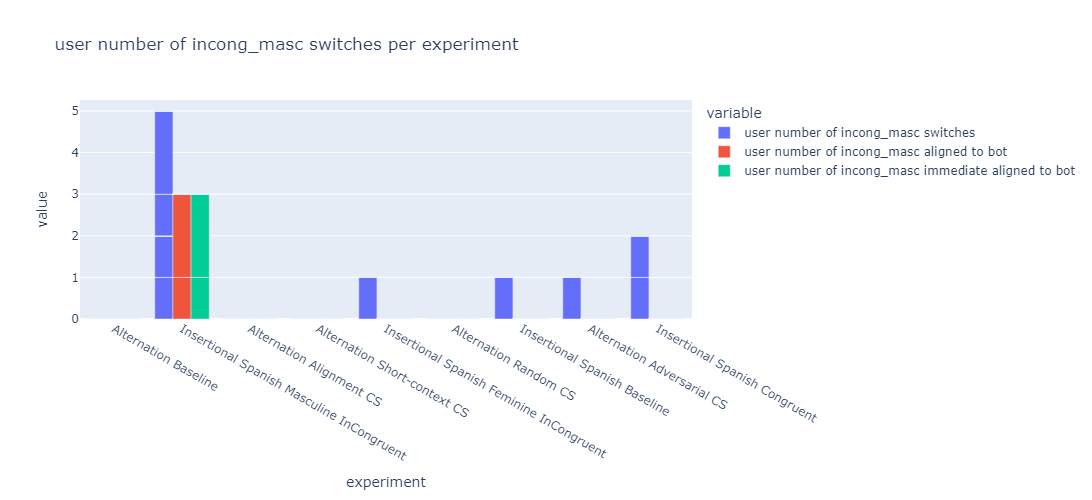

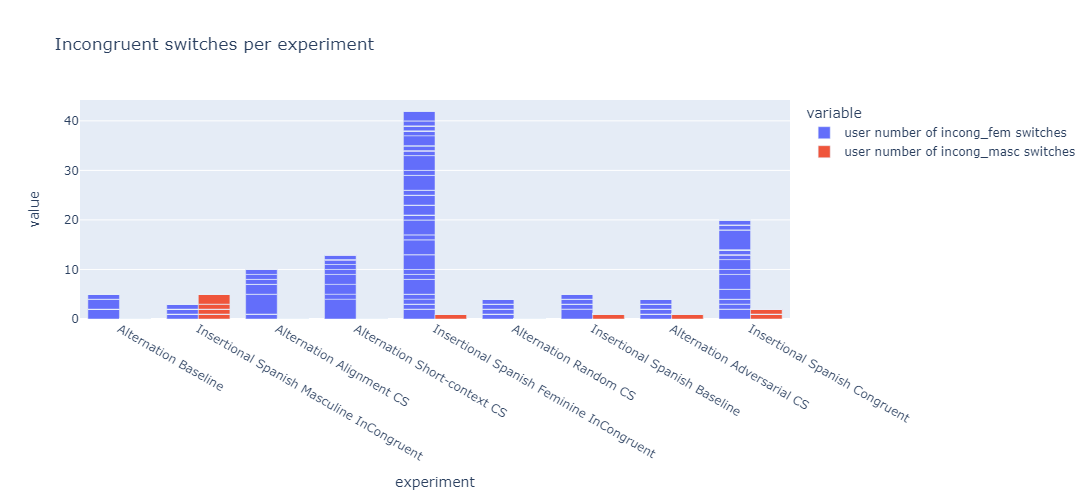

In [11]:
switch = 'incong_masc' #'incong_fem'
y_ = f'user number of {switch} switches'
ent1_y = f'user number of {switch} aligned to bot'
ent2_y = f'user number of {switch} immediate aligned to bot'

df_test = df_copy[df_copy[y_] > 0]
num_chats = df_test.shape[0]
num_partcipiants = len(df_test['pid'].unique())
num_swtiches = sum(df_test[y_])
print(f'{y_} - {num_partcipiants} participants, {num_chats} chats, {num_swtiches} switches')
print(df_test['human_role'].value_counts())

fig = px.bar(df_copy,
             x='experiment',
             y=[y_, ent1_y, ent2_y],
             barmode = 'group',
             orientation = "v",
             title=f"{y_} per experiment",
             width=800, height=500
            ).show()



fig = px.bar(df_copy,
             x='experiment',
             y=['user number of incong_fem switches', 'user number of incong_masc switches'],
             barmode = 'group',
             orientation = "v",
             title=f"Incongruent switches per experiment",
             width=800, height=500
            ).show()

In [12]:
# df_test[[ent1_y, y_,'experiment', 'pid']]

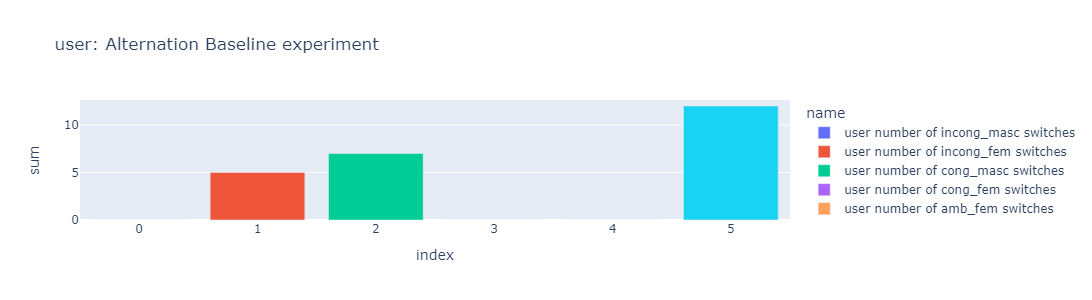

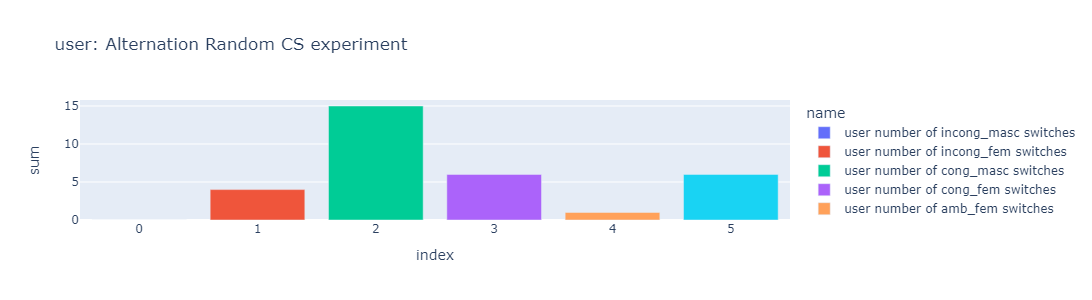

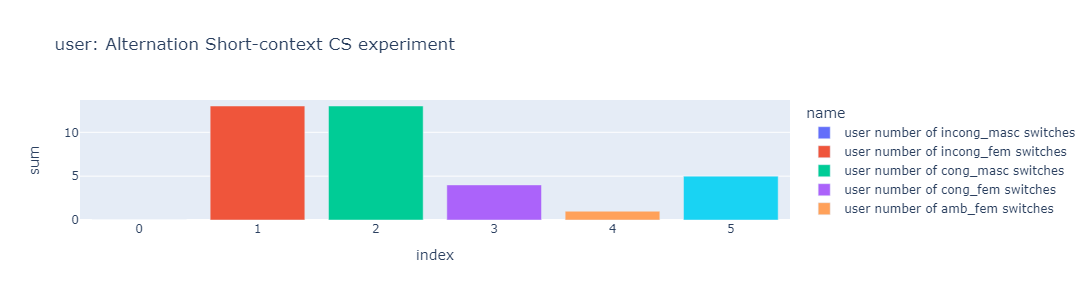

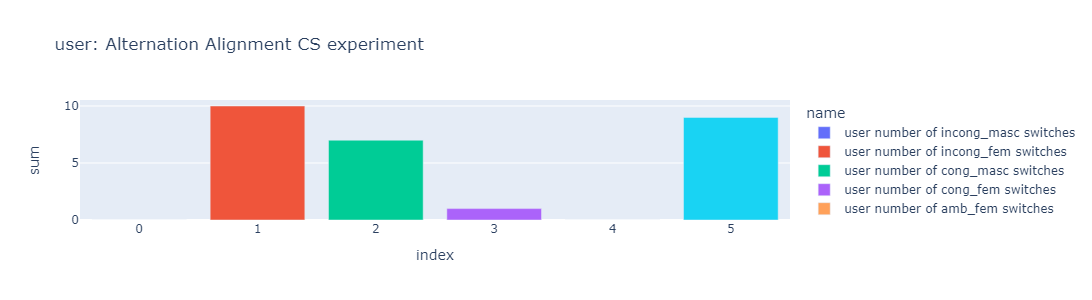

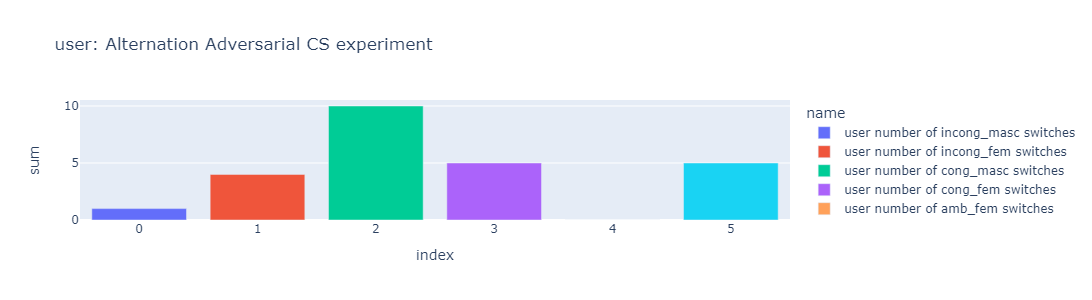

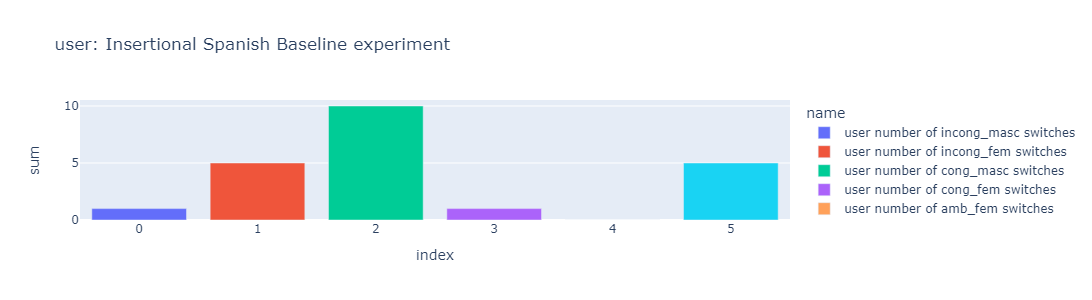

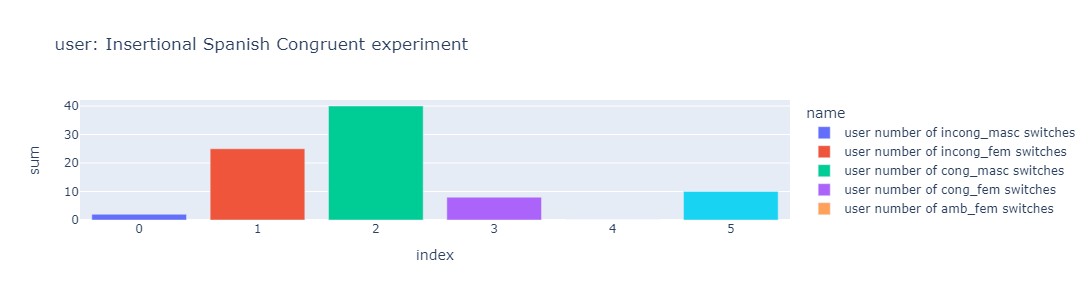

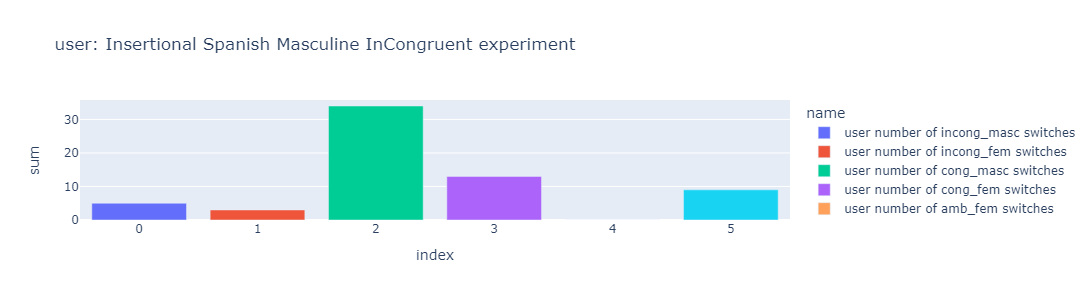

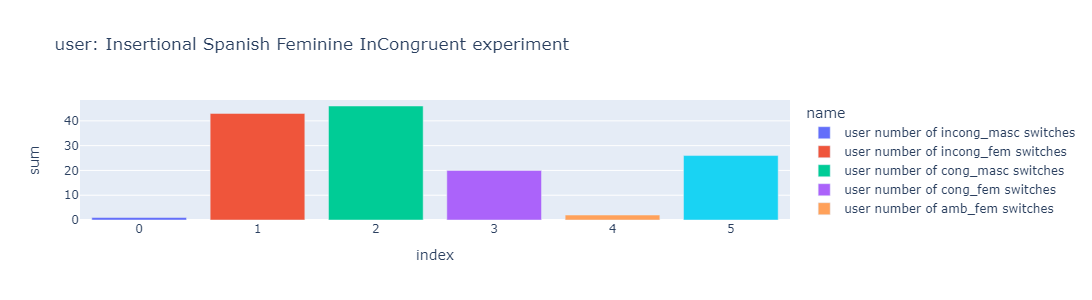

In [13]:
speaker = 'user' #'user
for exp in experiments:
    exp_df = get_experiment_df([exp])

    features = [
                f'{speaker} number of incong_masc switches',
                f'{speaker} number of incong_fem switches', 
                f'{speaker} number of cong_masc switches',
                f'{speaker} number of cong_fem switches',
                f'{speaker} number of amb_fem switches',
                f'{speaker} number of amb_masc switches'
                 ]
    sums_ = []
    for f in features:
        sums_.append(sum(exp_df[f]))
    
    tmp_df = pd.DataFrame.from_dict({'sum':sums_, 'name':features})
    fig = px.bar(tmp_df,
                 y='sum',
                 color='name',
                 title=f"{speaker}: {exp} experiment",
                 width=600, height=300).show()


In [14]:
# exp_idx = 3
# print(experiments[exp_idx])
# exp_df = get_experiment_df([experiments[exp_idx]])
# print(len(exp_df))

# y_ = f'{speaker} number of incong_masc switches'

# df_test = exp_df[exp_df[y_] > 0]

# num_chats = df_test.shape[0]
# num_partcipiants = len(df_test['pid'].unique())
# num_swtiches = sum(df_test[y_])
# print(f'{y_} - {num_partcipiants} participants, {num_chats} chats, {num_swtiches} switches')
# print(df_test['human_role'].value_counts())

# df_test

In [15]:
# df_corr = get_experiment_df(experiments)
# df_corr = remove_rename_columns(df_corr, True)
# df_corr.corr()

In [16]:
# y = 'user number of total ins switches'
# # y = "user number of utterances with some ins switch"
# # y = 'user number of incong_fem switches'

# plot_2d_scatter(df=df_copy,
#         x="dist_score",
#         y=y,
#         color='experiment',
#         size='game_time',
#         title=f'{role}')

# plot_2d_scatter(df=df_copy,
#         x="game_time",
#         y=y,
#         color='experiment',
#         size='game_time',
#         title=f'{role}')

# plot_2d_scatter(df=df_copy,
#         x="Q_enjoy_mix",
#         y=y,
#         color='experiment',
#         size='game_time',
#         title=f'{role}')

# plot_2d_scatter(df=df_copy,
#         x="Q_natural",
#         y=y,
#         color='experiment',
#         size='game_time',
#         title=f'{role}')


# plot_2d_scatter(df=df_copy,
#         x="Q_natural",
#         y="Q_enjoy_mix",
#         color='experiment',
#         size='game_time',
#         title=f'{role}')




In [17]:
y = 'user number of incong_masc switches'
y = 'user number of total ins switches'
y = "user number of utterances with some ins switch"
y = 'Mix %'
y = 'Inter-Sentential CS %'


# px.histogram(df_copy,  x='Mix %').show()

# px.histogram(df_copy,
#              y=y,
#              x='Mix %',  #Q_enjoy_mix #Q_mix_often
#              # color='experiment',
#              text_auto='.2f',
#              # histfunc='avg',
#             ).update_xaxes(categoryorder="array",categoryarray=list(range(100))).show()

# px.histogram(df_copy,
#              y=y,
#              x='lng_1',  #Q_enjoy_mix #Q_mix_often
#              # color='experiment',
#              text_auto='.2f',
#              histfunc='avg',
#             ).show()


In [18]:
# df_copy['Enter your native language, or the language you are providing answers for, here:'].value_counts()

In [19]:
df_copy['lng_2'].value_counts()

lng_2
ES      972
ENG     444
NONE     40
BOTH      8
Name: count, dtype: int64

In [20]:
# px.histogram(df_copy,
#              # y='lng1_prof',
#              x='lng1_prof',
#              # color='experiment',
#              text_auto='.2f',
#              # histfunc='avg',
#             ).show()

# px.histogram(df_copy,
#              # y='lng1_prof',
#              x='lng2_prof',
#              # color='experiment',
#              text_auto='.2f',
#              # histfunc='avg',
#             ).show()


# px.scatter(df_copy,
#              y='eng_prof',
#              x='spa_prof',
#              # color='experiment',
#              # histfunc='avg',
#             ).show()


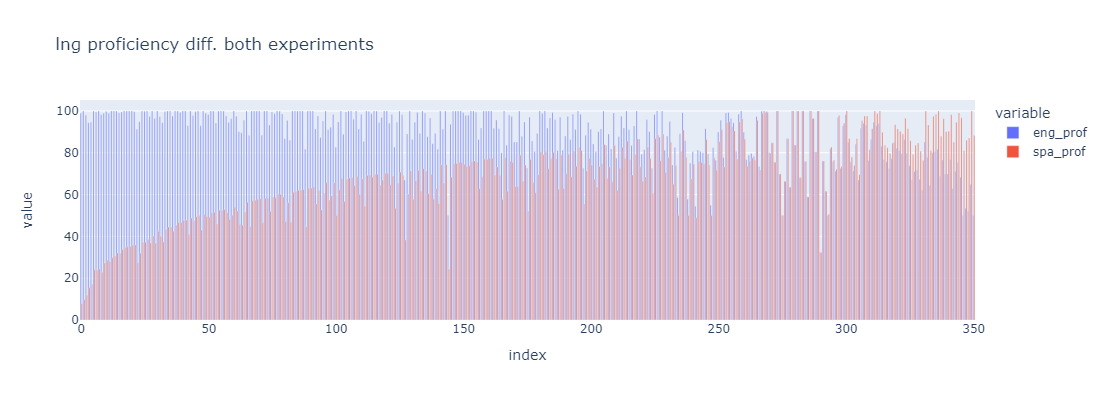

In [21]:
eng_prof = np.array(list(df_copy['eng_prof'])[0::4])
spa_prof = np.array(list(df_copy['spa_prof'])[0::4])
diff = eng_prof - spa_prof
# tmp_df['diff'] = tmp_df['eng_prof'] - tmp_df['spa_prof']

tmp_df = pd.DataFrame(
    {'eng_prof': eng_prof,
     'spa_prof': spa_prof,
     'diff': diff
    })

tmp_df = tmp_df.sort_values(by=['diff'], ascending=False)
tmp_df = tmp_df.dropna()
tmp_df.reset_index(drop=True, inplace=True)

fig = px.bar(tmp_df,
             # x='experiment',
             y=['eng_prof', 'spa_prof'],
             barmode = 'group',
             title=f"lng proficiency diff. {global_exp_} experiments",
             width=1100, height=400
            )

fig.show()


In [22]:
# px.bar(df_copy,
#              x='experiment',
#              color='lng_2',
# #                y='Q_enjoy',
#                barmode="group"
#             ).show()

# px.histogram(df_copy,
#              x='lng_2',
# #              y='Q_enjoy',
#              color='experiment',
#              text_auto='.2f',
#              histfunc='avg',
#              barmode="group",
#             ).show()
# # px.bar(df_copy,
# #              x='experiment',
# #              color='lng_2',
# #                barmode="group"
# #             ).show()

In [23]:
# import numpy as np
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import math


# def format_percentage(num: int) -> str:
#     return round(num * 100, 2)

# features=['user number of cong_masc switches',
#           'user number of cong_fem switches',
#           'user number of incong_masc switches', # incong 1
#           'user number of incong_fem switches', # incong 2
#           'user number of NP switches',
#           'user number of amb_masc switches', 
#           'user number of amb_fem switches']
# pies=[]

# mean_num_uter_w_cong_cs_normal_values = []
# mean_num_of_total_cong_switch = []
# masc_det = []
# fem_det = []

# for exp in experiments:
#     exp_df = get_experiment_df([exp])
#     exp_df = remove_rename_columns(exp_df)

#     #bar plot
#     mean_utters = np.mean(exp_df['user number of utterances'])
#     mean_num_uter_w_cong_cs = np.mean(exp_df['user number of utterances with some ins switch'])
#     mean_num_uter_w_cong_cs_normal_values.append(format_percentage(mean_num_uter_w_cong_cs / mean_utters))

#     mean_num_of_total_cong_switch.append(round(np.mean(exp_df['user number of total ins switches']),2))

#     total_det_cs = np.sum(exp_df['user number of masc det switches']) + np.sum(exp_df['user number of fem det switches'])
    
#     masc_det.append(round(np.sum(exp_df['user number of masc det switches'])/total_det_cs,2))
#     fem_det.append(round(np.sum(exp_df['user number of fem det switches'])/total_det_cs,2))

#     # distribution of cong types
#     means_ = {}
#     for f in features:
#         means_[f] = np.mean(exp_df[f]) / np.mean(exp_df['user number of total ins switches'])

#     labels = list(means_.keys())
#     labels = [l[5:] for l in labels]
#     values = list(means_.values())
#     pies.append(go.Pie(labels=labels,values=values, sort=False,title=exp))


# rows = math.ceil(len(pies) /2)
# specs = [[{"type": "domain"}, {"type": "domain"}]] * rows
# opts = [(1,1), (1,2), (2,1), (2,2), (3,1)]
# fig = make_subplots(
#     rows=rows, cols=2,
#     specs=specs,
# )

# for idx, p in enumerate(pies):
#     row, col = opts[idx]
#     fig.add_trace(p,row=row, col=col)

# # fig.update_layout(height=800, width=800)
#     fig.update_layout(
#     width=900,
#     height=800,
#     title={
#     'text': 'Distribution of insertional CS',
#     'y':0.9,
#     'x':0.5,
#     'xanchor': 'center',
#     'yanchor': 'top'},
# )
# fig.show()

# fig = go.Figure()
# fig.add_trace(go.Bar(x=experiments,
#                     name='mean number of utterances with some insertional CS (%)',
#                     y=mean_num_uter_w_cong_cs_normal_values,
#                     text=mean_num_uter_w_cong_cs_normal_values))
# fig.add_trace(go.Bar(x=experiments,
#                     name='mean number of total insertional CS occurrences (per dialog)',
#                     y=mean_num_of_total_cong_switch,
#                     text=mean_num_of_total_cong_switch))
# fig.update_layout(barmode='stack',width=1000,height=500)
# fig.show()

# fig = go.Figure()
# fig.add_trace(go.Bar(x=experiments,
#                     name='masc determiner CS (%)',
#                     y=masc_det,
#                     text=masc_det))
# fig.add_trace(go.Bar(x=experiments,
#                     name='fem determiner CS (%)',
#                     y=fem_det,
#                     text=fem_det))
# fig.update_layout(width=1000,height=500)
# fig.show()


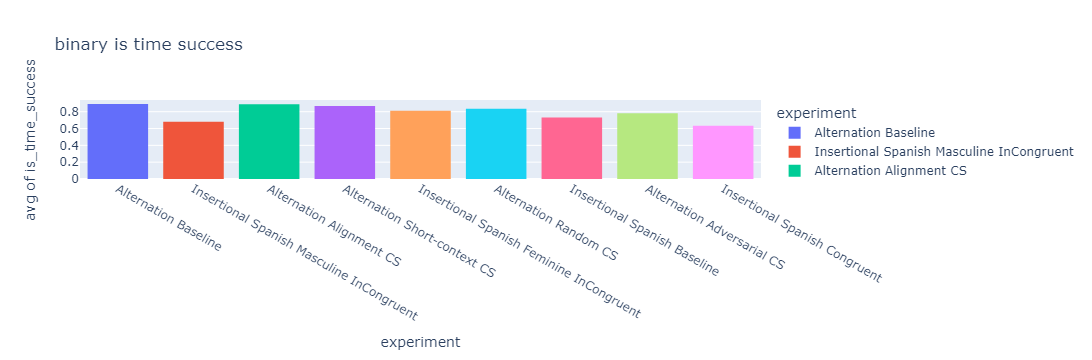

In [24]:
fig = px.histogram(df_copy,
             x='experiment',
             y='is_time_success',
             # points="all",
             histfunc='avg',
             color='experiment',
             title="binary is time success",
            ).show()

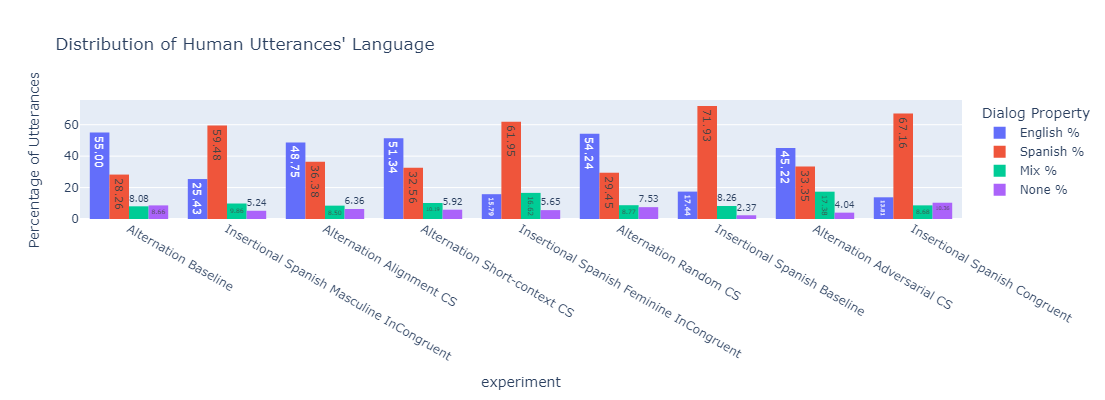

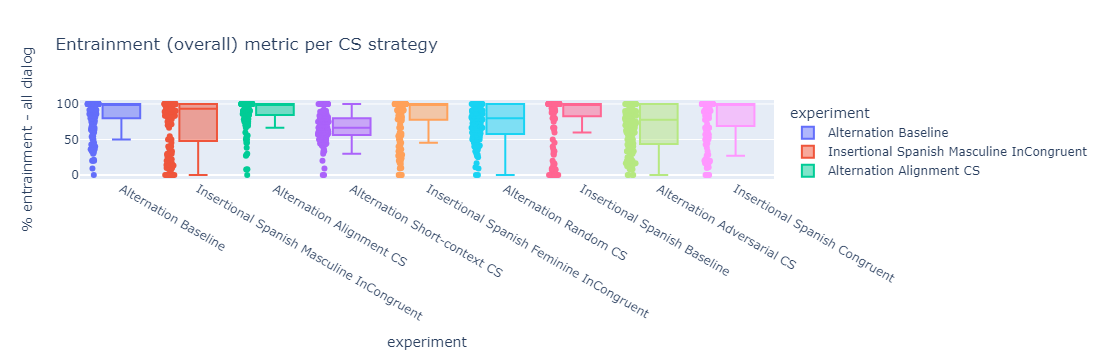

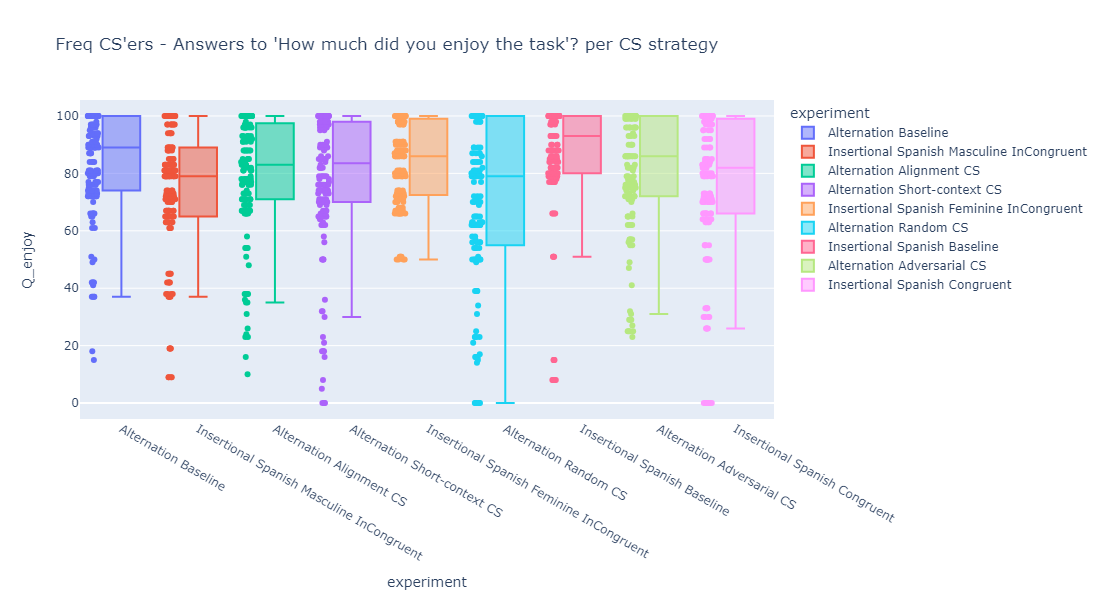

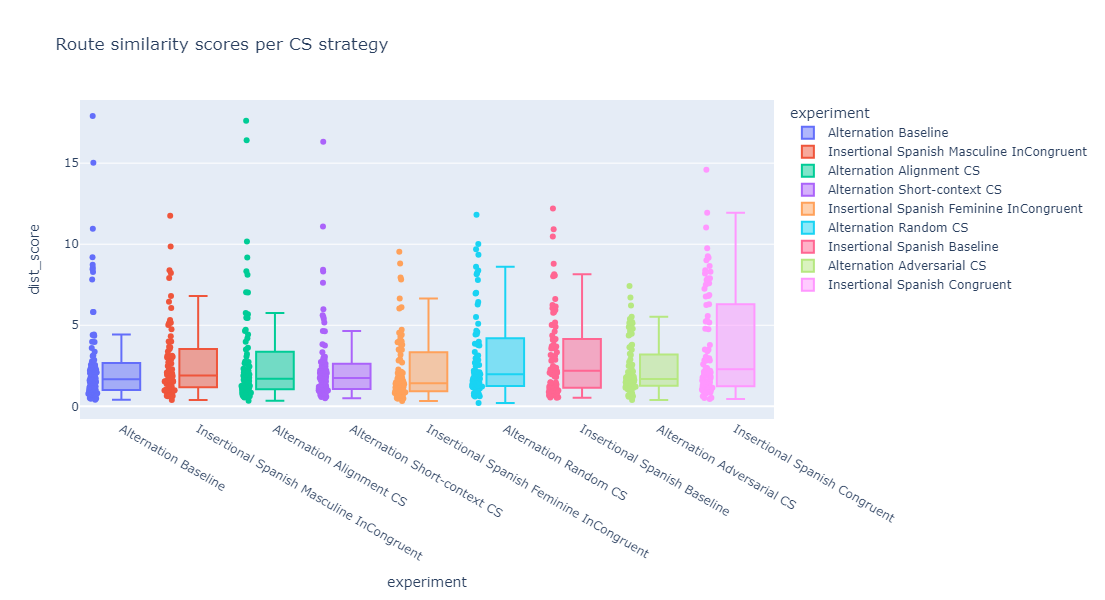

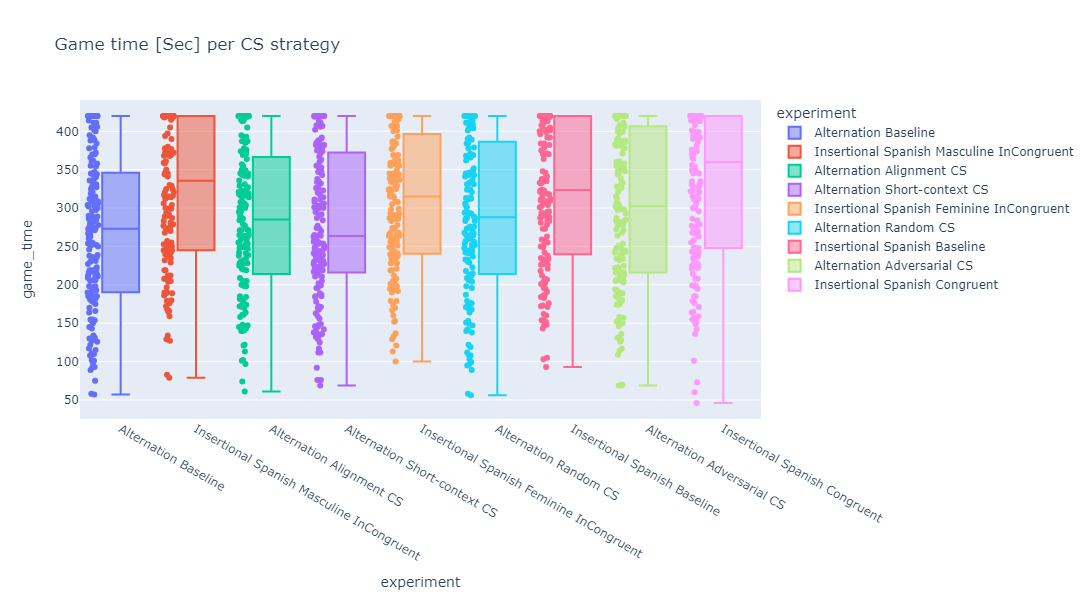

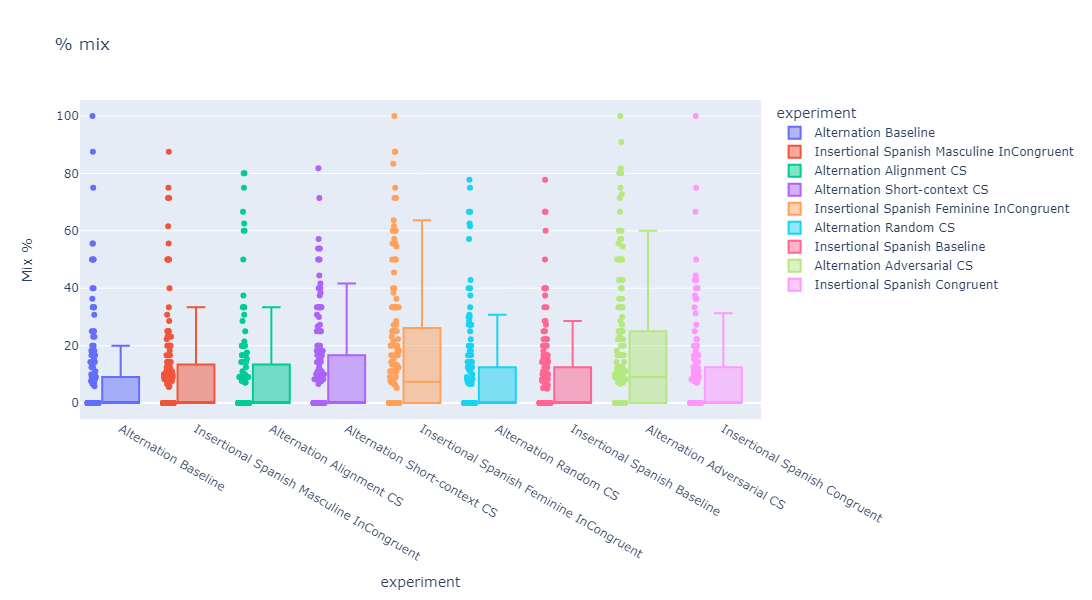

In [25]:
features=['English %', 'Spanish %', 'Mix %', 'None %'] # "Inter-Sentential CS %"]
fig = px.histogram(df_copy,
             x='experiment',
             y=features,
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
             width=1000, height=400,
             title="Distribution of Human Utterances' Language",
            )

fig.update_layout(
    yaxis_title="Percentage of Utterances",
    legend_title="Dialog Property",
)
fig.show()

# features=["Inter-Sentential CS %"]
# fig = px.histogram(df_copy,
#              x='experiment',
#              y=features,
#              text_auto='.2f',
#              histfunc='avg',
#              barmode="group",
#              title="Inter-Sentential CS %",
#             )
# fig.show()


# if global_exp_ == 'ins':
#     features=['Q_successful', 'Q_enjoy', 'Q_enjoy_mix', 'Q_mix_friends', 'Q_mix_often', 'Q_natural']
# else:
#     features=['Q_successful', 'Q_enjoy', 'Q_enjoy_mix', 'Q_mix_friends']
# px.histogram(df_copy,
#              x='experiment',
#              y=features,
#              text_auto='.2f',
#              histfunc='avg',
#              barmode="group",
#             ).show()

# fig = px.box(df_copy,
#              x='experiment',
#              y="Inter-Sentential CS %",
#              points="all",
#              color='experiment',
#              title="Inter-Sentential CS (%) metric per CS strategy",
#             ).show()

# px.histogram(df_copy,
#              x='experiment',
#              y=['% entrainment - all dialog', '% entrainment - on bot inter-sentential cs'],
#              text_auto='.2f',
#              histfunc='avg',
#              barmode="group",
#             ).show()


# fig = px.box(df_copy,
#              x='experiment',
#              y='% entrainment - on bot inter-sentential cs',
#              points="all",
#              color='experiment',
#              title="Entrainment metric (on bot inter-sentential cs) per CS strategy",
#             ).show()



fig = px.box(df_copy,
             x='experiment',
             y='% entrainment - all dialog',
             points="all",
             color='experiment',
             title="Entrainment (overall) metric per CS strategy",
            ).show()

fig = px.box(df_copy,
             x='experiment',
             y='Q_enjoy',
             points="all",
             color='experiment',
             title="Freq CS'ers - Answers to 'How much did you enjoy the task'? per CS strategy",
             width=1000, height=600
            ).show()

fig = px.box(df_copy,
             x='experiment',
             y='dist_score',
             points="all",
             color='experiment',
             title="Route similarity scores per CS strategy",
             width=1000, height=600
            ).show()

fig = px.box(df_copy,
             x='experiment',
             y='game_time',
             points="all",
             color='experiment',
             title="Game time [Sec] per CS strategy",
             width=1000, height=600
            ).show()

fig = px.box(df_copy,
             x='experiment',
             y='Mix %',
             points="all",
             color='experiment',
             title="% mix",
             width=1000, height=600
            ).show()


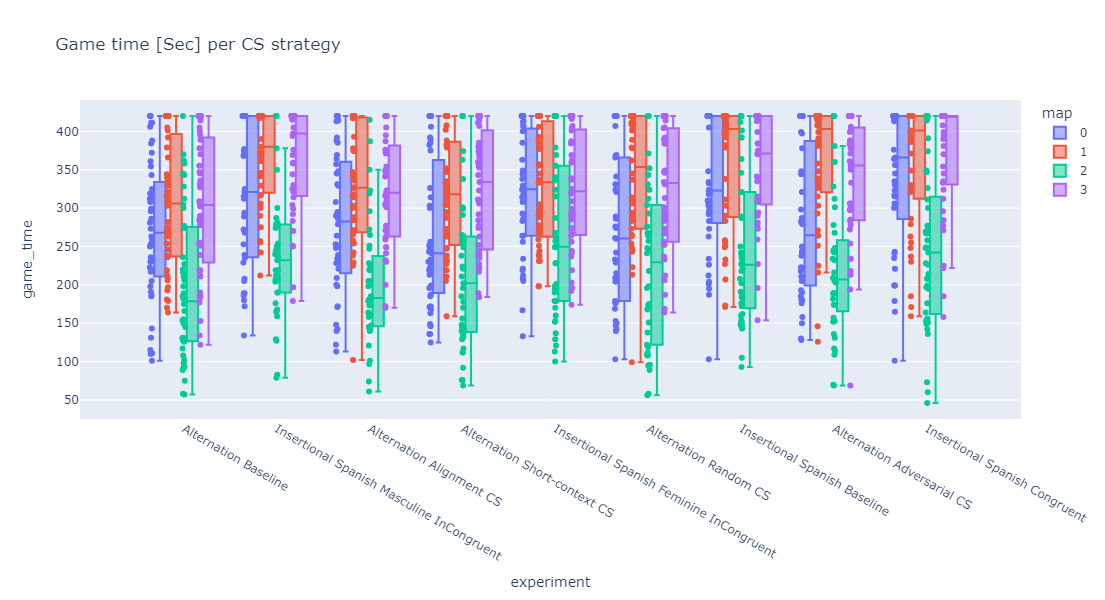

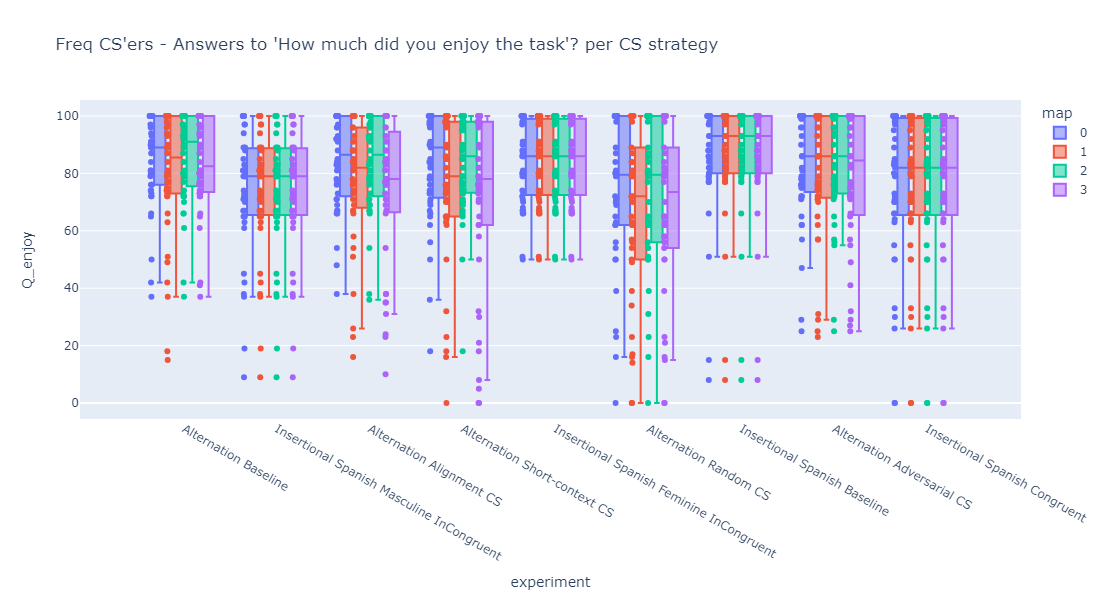

In [26]:
fig = px.box(df_copy,
             x='experiment',
             y='game_time',
             points="all",
             color='map',
             title="Game time [Sec] per CS strategy",
             width=1000, height=600
            ).show()

fig = px.box(df_copy,
             x='experiment',
             y='Q_enjoy',
             points="all",
             color='map',
             title="Freq CS'ers - Answers to 'How much did you enjoy the task'? per CS strategy",
             width=1000, height=600
            ).show()

In [27]:
for c in df_copy.columns:
    print(c)

experiment
human_role
map
pid
game_time
is_time_success
user number of utterances
user mean utterance length
user total number of tokens
user number of eng utterances
user number of es utterances
user number of mix utterances
user number of none utterances
user number of inter-sentential cs
user number of utterances with some ins switch
user number of total ins switches
user number of cong_masc switches
user number of cong_fem switches
user number of incong_masc switches
user number of incong_fem switches
user number of NP switches
user number of amb_masc switches
user number of amb_fem switches
user number of masc det switches
user number of fem det switches
user % entrainment - all dialog
user % entrainment - on bot inter-sentential cs
user number of cong_masc aligned to bot
user number of cong_fem aligned to bot
user number of incong_masc aligned to bot
user number of incong_fem aligned to bot
user number of NP aligned to bot
user number of amb_masc aligned to bot
user number of amb

In [56]:
# print('# of dialogs')
# print(df.groupby('experiment').size())
# print(df.groupby('experiment').size().sum())
pd.options.display.float_format = "{:,.2f}".format

agg_dict = {
    'is_time_success': 'mean',
    'experiment': 'count',
    # 'user number of utterances': 'mean',
    # 'user mean utterance length': 'mean',
    # 'user total number of tokens': 'mean',
    'dist_score':'mean',
    'game_time': 'mean',
    'user % entrainment - all dialog': 'mean',
    # 'user number of utterances with some ins switch' : 'sum',
    # 'user number of total ins switches': 'sum',
    # 'user number of incong_masc switches': 'sum',
    # 'user number of incong_fem switches': 'sum',
    # 'user number of cong_masc switches': 'sum',
    # 'user number of cong_fem switches': 'sum',
    # 'user number of NP switches': 'sum',
    # 'user number of amb_masc switches': 'sum',
    # 'user number of amb_fem switches':'sum',
    'Q_enjoy': 'mean',
    'Q_successful': 'mean',
    'Q_mix_friends': 'mean',
    'Q_enjoy_mix': 'mean',
    'Q_difficuly_comm': 'mean',
    'Q_difficuly_ins': 'mean',
    'eng_prof': 'mean',
    'spa_prof': 'mean',
    # 'Q_natural': 'mean', #only in INS experiment
    'Mix %' : 'mean',
    'Inter-Sentential CS %': 'mean',
           }

# df_copy.groupby('experiment').agg(agg_dict).describe()


In [57]:
stats = df_copy[list(agg_dict)].describe().iloc[[1,2]]
df_copy[list(agg_dict)].describe()

is_time_success  dist_score  game_time  \
count         1,464.00      732.00   1,464.00   
mean              0.79        2.82     299.59   
std               0.41        2.66      98.61   
min               0.00        0.20      46.00   
25%               1.00        1.13     223.00   
50%               1.00        1.81     304.00   
75%               1.00        3.57     402.25   
max               1.00       17.91     420.00   

       user % entrainment - all dialog  Q_enjoy  Q_successful  Q_mix_friends  \
count                         1,464.00 1,464.00      1,464.00       1,464.00   
mean                              0.78    79.33         70.84          53.58   
std                               0.29    22.53         23.56          33.33   
min                               0.00     0.00          0.00           0.00   
25%                               0.63    70.00         60.00          21.00   
50%                               0.91    83.00         75.00          62.00   
75%                               1.00   100.00         88.00          80.00   
max                               1.00   100.00        100.00         100.00   

       Q_enjoy_mix  Q_difficuly_comm  Q_difficuly_ins  eng_prof  spa_prof  \
count     1,464.00          1,464.00         1,464.00  1,432.00  1,424.00   
mean         59.15             36.06            34.46     89.38     67.80   
std          31.42             29.32            28.11     12.38     19.35   
min           0.00              0.00             0.00     32.25      7.78   
25%          35.00             12.00            10.00     81.78     56.03   
50%          67.00             29.00            28.00     94.33     69.78   
75%          83.00             61.00            59.00     99.89     80.50   
max         100.00            100.00           100.00    100.00    100.00   

         Mix %  Inter-Sentential CS %  
count 1,464.00               1,457.00  
mean     10.67                  10.18  
std      17.96                  19.54  
min       0.00                   0.00  
25%       0.00                   0.00  
50%       0.00                   0.00  
75%      14.29                  12.50  
max     100.00                 100.00

In [58]:
tmp = df_copy.copy()
for exp in experiments:
    basic_exp = exp.split()[0]
    tmp['experiment'] = tmp['experiment'].str.replace(exp, basic_exp)
all_agg = tmp.groupby('experiment').agg(agg_dict)

In [59]:
agg = df_copy.groupby('experiment').agg(agg_dict)
r = pd.concat([stats, agg, all_agg])
r['is_time_success'] = r['is_time_success']*100
r

is_time_success  dist_score  \
mean                                                 79.23        2.82   
std                                                  40.58        2.66   
Alternation Adversarial CS                           78.12        2.36   
Alternation Alignment CS                             88.75        2.84   
Alternation Baseline                                 89.20        2.71   
Alternation Random CS                                83.55        3.13   
Alternation Short-context CS                         86.63        2.46   
Insertional Spanish Baseline                         73.17        3.10   
Insertional Spanish Congruent                        63.41        3.79   
Insertional Spanish Feminine InCongruent             81.25        2.28   
Insertional Spanish Masculine InCongruent            67.95        2.75   
Alternation                                          85.37        2.69   
Insertional                                          71.43        2.99   

                                           game_time  \
mean                                          299.59   
std                                            98.61   
Alternation Adversarial CS                    300.43   
Alternation Alignment CS                      283.13   
Alternation Baseline                          269.32   
Alternation Random CS                         288.55   
Alternation Short-context CS                  279.41   
Insertional Spanish Baseline                  320.02   
Insertional Spanish Congruent                 328.29   
Insertional Spanish Feminine InCongruent      308.11   
Insertional Spanish Masculine InCongruent     322.37   
Alternation                                   283.77   
Insertional                                   319.74   

                                           user % entrainment - all dialog  \
mean                                                                  0.78   
std                                                                   0.29   
Alternation Adversarial CS                                            0.69   
Alternation Alignment CS                                              0.89   
Alternation Baseline                                                  0.85   
Alternation Random CS                                                 0.74   
Alternation Short-context CS                                          0.67   
Insertional Spanish Baseline                                          0.81   
Insertional Spanish Congruent                                         0.82   
Insertional Spanish Feminine InCongruent                              0.82   
Insertional Spanish Masculine InCongruent                             0.75   
Alternation                                                           0.77   
Insertional                                                           0.80   

                                           Q_enjoy  Q_successful  \
mean                                         79.33         70.84   
std                                          22.53         23.56   
Alternation Adversarial CS                   80.93         73.49   
Alternation Alignment CS                     79.52         72.91   
Alternation Baseline                         83.60         73.92   
Alternation Random CS                        70.11         65.90   
Alternation Short-context CS                 78.47         71.87   
Insertional Spanish Baseline                 86.73         67.88   
Insertional Spanish Congruent                75.61         67.56   
Insertional Spanish Feminine InCongruent     84.00         75.00   
Insertional Spanish Masculine InCongruent    73.92         68.46   
Alternation                                  78.71         71.72   
Insertional                                  80.12         69.71   

                                           Q_mix_friends  Q_enjoy_mix  \
mean                                               53.58        59.15   
std                          

In [32]:
print(df_copy['experiment'].value_counts())
print(np.mean(list(df_copy['experiment'].value_counts())))
print(np.std(list(df_copy['experiment'].value_counts())))

experiment
Alternation Baseline                         176
Alternation Short-context CS                 172
Insertional Spanish Baseline                 164
Insertional Spanish Congruent                164
Alternation Alignment CS                     160
Insertional Spanish Feminine InCongruent     160
Alternation Adversarial CS                   160
Insertional Spanish Masculine InCongruent    156
Alternation Random CS                        152
Name: count, dtype: int64
162.66666666666666
7.055336829505575
